# XRD Clustering using SOM only

No Dimensionality reduction

In [1]:
import h5py   # read raw data
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from minisom import MiniSom   # clustering analysis


In [2]:

path = r"D:\Masters project\DiffractionImages\run264369-0.h5"
datafile = r"D:\ml_data_V2.dat"

# Target shape for ML (Much smaller than 1700x1700)
# 128x128 = 16,384 features (manageable for SOM/NMF)
TARGET_SHAPE = (128, 128) 


In [3]:
def stream_and_resize(filename, target_shape):    # process each image individually
    with h5py.File(filename, "r") as f:
        keys = [k for k in f.keys() if k != "metadata" and "data" in f[k]]
        for key in keys:
            data = f[key]["data"][()]
            # Log scale helps with high dynamic range of XRD
            # ML model would ignore subtle diffraction rings if we used the raw intensity
            data_log = np.log1p(np.abs(data)) 
            # Resize (anti-aliasing preserves peaks). Ensure diffraction rings dont disappear between pixels during shrinking process
            data_resized = resize(data_log, target_shape, anti_aliasing=True)
            yield data_resized.flatten()
            
# Count items to initialize numpy memory map (memmap)
with h5py.File(path, 'r') as f:
    num_items = len([k for k in f.keys() if k != "metadata" and "data" in f[k]])

# Calculate flat feature size
feature_size = TARGET_SHAPE[0] * TARGET_SHAPE[1]

# Create memmap with float32 (standard for ML)
X_mm = np.memmap(datafile, dtype='float32', mode='w+', shape=(num_items, feature_size))

# Execution loop. Generator reads a raw image, log-scales and resizes it.
for i, sample in enumerate(stream_and_resize(path, TARGET_SHAPE)):
    X_mm[i] = sample       # Assign processed vector into row i of memory mapped file
    if i % 100 == 0: print(f"Processed {i}/{num_items}")

# Flush changes to disk
X_mm.flush()
print("Data preparation complete.")

Processed 0/2718
Processed 100/2718
Processed 200/2718
Processed 300/2718
Processed 400/2718
Processed 500/2718
Processed 600/2718
Processed 700/2718
Processed 800/2718
Processed 900/2718
Processed 1000/2718
Processed 1100/2718
Processed 1200/2718
Processed 1300/2718
Processed 1400/2718
Processed 1500/2718
Processed 1600/2718
Processed 1700/2718
Processed 1800/2718
Processed 1900/2718
Processed 2000/2718
Processed 2100/2718
Processed 2200/2718
Processed 2300/2718
Processed 2400/2718
Processed 2500/2718
Processed 2600/2718
Processed 2700/2718
Data preparation complete.


In [4]:
# Machine Learning

# Load data (Read mode)
X = np.memmap(datafile, dtype='float32', mode='r', shape=(num_items, feature_size))

# Initialize SOM
# A 20x20 grid (400 neurons) is decent for 2700 samples
som_dim = 20 
som = MiniSom(som_dim, som_dim, X.shape[1], sigma=1.0, learning_rate=0.5)  

# Initialize weights to random samples (helps convergence / speeds up training)
som.random_weights_init(X)

som.train_random(X, 10000) # Train for 10k iterations. Algorithm picks an image, finds the neuron that looks most like the image, then tweaks that neuron to look even more like the image.
print("Training Done.")

# Analyze Index Trajectories
# We map every image index to a coordinate on the SOM grid. Allows to visualise trajectory
coordinates = np.array([som.winner(x) for x in X])


Training Done.


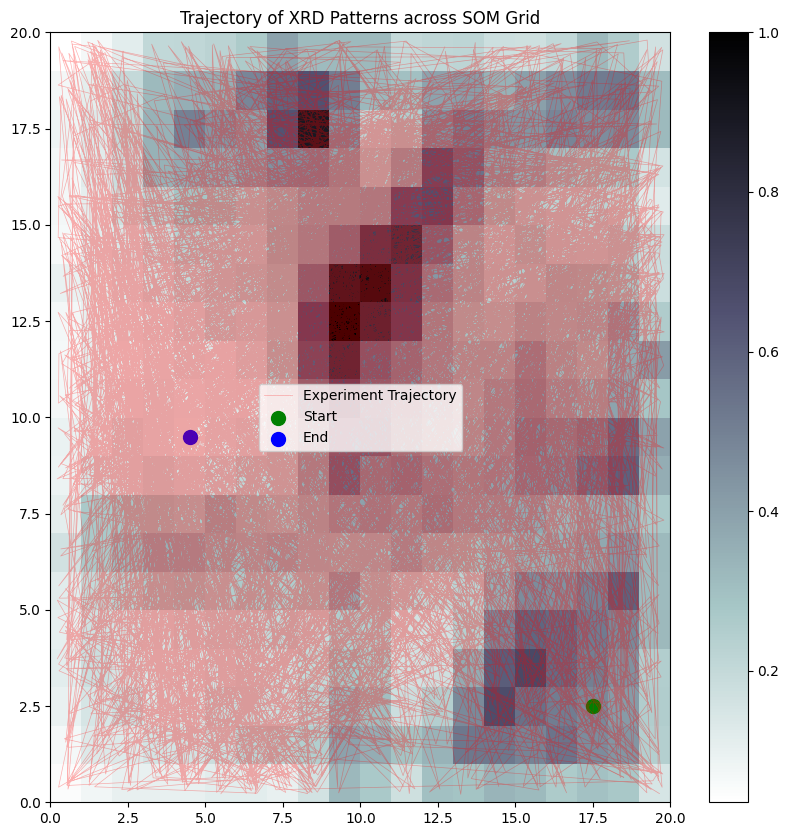

In [5]:

# Plotting the "Trajectory" of the experiment
plt.figure(figsize=(10, 10))

# Plot the U-Matrix (background colors showing cluster separation)
# Darker areas = valleys (clusters / stable crystal phases), Lighter areas = ridges (boundaries / transitions between phases)
plt.pcolor(som.distance_map().T, cmap='bone_r') # Calculates Euclidean distance between neuron and its neighbours
plt.colorbar()

# Overlay the path of the images (0 to 2700)
# Add a small jitter to seeing overlapping points
jitter = np.random.rand(len(coordinates), 2) * 0.6 + 0.2
plt.plot(coordinates[:, 0] + jitter[:, 0], coordinates[:, 1] + jitter[:, 1], 
         c='red', alpha=0.3, linewidth=0.5, label='Experiment Trajectory')

# Highlight Start and End
plt.scatter(coordinates[0, 0]+0.5, coordinates[0, 1]+0.5, c='green', s=100, label='Start')
plt.scatter(coordinates[-1, 0]+0.5, coordinates[-1, 1]+0.5, c='blue', s=100, label='End')

plt.legend()
plt.title("Trajectory of XRD Patterns across SOM Grid")
plt.show()